# Clinical task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from clinical_notes import TaskGenerator

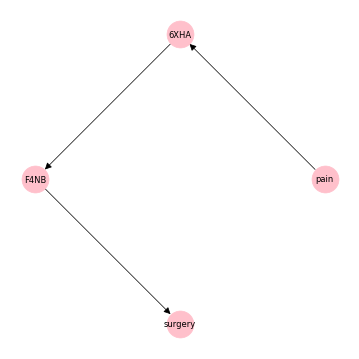


Context: Chronic disease 9A1G4R sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele HU5O, a genetic marker for severe 9A1G4R. If the patient self-reports significant pain or the patient has previously received surgery for 0OU4, then lab 6XHA will be elevated (greater than 3.26 mg/dL). If 6XHA is elevated or the patient carries allele KEOW, then lab F4NB will be low (less than 1.2 mg/dL). If F4NB is low and the patient has previously received surgery for WQFS, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Pamela White. History of Present Illness: Pamela White is a 68-year-old female with 9A1G4R who presented to the emergency department with acute onset pain that began 3 hours p

In [2]:
tg = TaskGenerator(n_per_bcc = [2,2,2], 
                   bcc_types = ["cycle", "wheel", "cycle"],)
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
true = tg.get_truth(intervene_node = None, intervene_value = 0)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
#print("- True endogenous variable values:", true)
#print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [3]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 0, '6XHA': 1, 'F4NB': 1, 'surgery': 0},
  'True exogenous': {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0},
  'True response': 0},
 '6XHA': {'Prompt': 'Will lab 6XHA be elevated? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 0, '6XHA': 1, 'F4NB': 1, 'surgery': 0},
  'True exogenous': {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0},
  'True response': 1},
 'F4NB': {'Prompt': 'Will lab F4NB be low? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 0, '6XHA': 1, 'F4NB': 1, 'surgery': 0},
  'True exogenous': {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0},
  'True response': 1}}

In [4]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 1, '6XHA': 1, 'F4NB': 1, 'surgery': 0}
True exogenous: {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0}
True response: 0

-----------------------

-- ('pain', '6XHA') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will lab 6XHA be elevated? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 1, '6XHA': 1, 'F4NB': 1, 'surgery': 0}
True exogenous: {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0}
True response: 1

-----------------------

-- ('pain', 'F4NB') --
Prompt: Now suppose that the patient will be in significant 

In [5]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 0, '6XHA': 1, 'F4NB': 1, 'surgery': 0}
True exogenous: {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0}
True response: 0

-----------------------

-- ('pain', '6XHA') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will lab 6XHA be elevated? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 0, '6XHA': 1, 'F4NB': 1, 'surgery': 0}
True exogenous: {'HU5O': 0, '0OU4': 1, 'KEOW': 1, 'WQFS': 0}
True response: 1

-----------------------

-- ('pain', 'F4NB') --
Prompt: Now suppose that the patient will not be in pain regardless of all 

In [6]:
df_obs, df_noise = tg.sample_scm(n = 3,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,6XHA,F4NB,surgery
0,1,1,1,0
1,1,1,1,0
2,0,0,0,0


,HU5O,0OU4,KEOW,WQFS
0,1,0,1,0
1,1,0,1,0
2,0,0,0,1


## Generate dataset

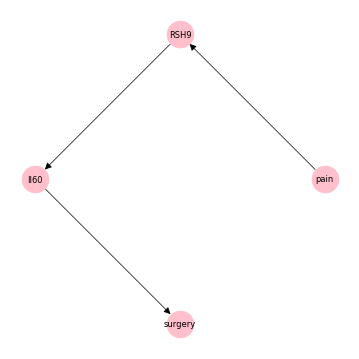

,Task ID,Causal context,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Global quantity,Local quantities,Compositions,Patient history,Factual queries,Counterfactual queries (cause = True),Counterfactual queries (cause = False)
0,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
5,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
6,0,Chronic disease 1QPB4P sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, RSH9, II60, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, RSH9, II60, surgery]","(pain, surgery)","[(pain, RSH9), (pain, II60), (RSH9, II60), (RS...","[[(pain, RSH9), (RSH9, II60), (II60, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Will the surgeon recom...,"{('pain', 'surgery'): {'Prompt': 'Now su

In [15]:
n = 10
tg = TaskGenerator(n_per_bcc = [2,2,2], 
                       bcc_types = ["cycle", "cycle", "cycle"])
context = [tg.get_causal_context()]*n
adj_dag = [tg.adj_dag]*n
nodes_dag = [tg.nodes]*n
adj_cct = [tg.adj_cct]*n
nodes_cct = [list(tg.cct.nodes())]*n

global_qs = [tg.get_global()]*n
local_qs = [tg.get_local()]*n
compositions = [tg.get_compositions()]*n

patient_histories = []
factual_queries = []
cf_1_queries = []
cf_0_queries = []


for i in range(n):
    patient_histories.append(tg.get_patient_history(n_extra_vars = 2))
    factual_queries.append(tg.get_factual_queries())
    cf_1, cf_0 = tg.get_counterfactual_queries()
    cf_1_queries.append(cf_1)
    cf_0_queries.append(cf_0)

df = pd.DataFrame({
    "Task ID": [0]*n, 
    "Causal context": context, 
    "DAG adjacency matrix": adj_dag, 
    "DAG nodes": nodes_dag,
    "CCT adjacency matrix": adj_cct, 
    "CCT nodes": nodes_cct,
    "Global quantity": global_qs,
    "Local quantities": local_qs,
    "Compositions": compositions,
    "Patient history": patient_histories, 
    "Factual queries": factual_queries, 
    "Counterfactual queries (cause = True)": cf_1_queries, 
    "Counterfactual queries (cause = False)": cf_0_queries
})

df

In [18]:
context[0]

'Chronic disease 1QPB4P sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele AUKR, a genetic marker for severe 1QPB4P. If the patient self-reports significant pain or the patient carries allele FFJE, then vital RSH9 will be low (less than 3.14 mg/dL). If RSH9 is low or the patient has a family history of D6QL, then lab II60 will be low (less than 1.12 mg/dL). If II60 is low and the patient carries allele AFRJ, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.'

In [16]:
patient_histories

['Now, we will review the history and physical notes for patient Michael Ellis. History of Present Illness: Michael Ellis is a 53-year-old male with 1QPB4P who presented to the emergency department with acute onset pain that began 5 hours prior to arrival. Pain was rated 2/10. The patient reports the pain has been persistent since onset. The patient took aspirin (250 mg) at home with minimal relief.\nGenetic Screening: Patient carries alleles AFRJ, D72C, JCS9.\nFamily History: D6QL, CRVW, MBL1.\nMedications: F6A 25 mg/day.\nPast Surgical History: Prior surgeries for 5WZ2, OJC7.',
 'Now, we will review the history and physical notes for patient Patrick Freeman. History of Present Illness: Patrick Freeman is a 63-year-old male with 1QPB4P who presented to the emergency department with acute onset pain that began 3 hours prior to arrival. Pain was rated 10/10. The patient reports the pain has been persistent since onset. The patient took aspirin (500 mg) at home with minimal relief.\nGene